# School distance to houses

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pyspark.sql import functions as F  #filtering
import geopandas as gpd
import folium
from folium import GeoJsonTooltip
import openrouteservice
import time
from geopy.distance import geodesic
import numpy as np
import pandas as pd


In [2]:
# import the parquet file
house = pd.read_parquet('../data/landing/domain_cleaned/part-00000-7dc1f449-c232-484e-b4e6-1dfbe30d6a77-c000.snappy.parquet')

In [3]:
# import school data
school = pd.read_csv('../data/raw/school.csv')

In [4]:
# percentage of primary schools that are in the government Education Sector
school[school['School_Type'] == 'Primary']['Education_Sector'].value_counts(normalize=True) * 100

Education_Sector
Government     67.587209
Catholic       30.087209
Independent     2.325581
Name: proportion, dtype: float64

## Distance to closest school

In [5]:
def find_closest_school_with_progress(house, school):
    # Convert lat/lon data to NumPy arrays for fast vectorized computation
    house_coords = house[['latitude', 'longitude']].to_numpy()
    school_coords = school[['latitude', 'longitude']].to_numpy()

    # Create arrays to store the closest school distances and indices for each house
    closest_school_distances = []
    closest_school_indices = []

    # Loop over each house and show progress
    total_houses = len(house_coords)
    last_percent_shown = 0  # Track the last percentage shown
    
    for i, house_coord in enumerate(house_coords):
        # Calculate the geodesic distance from this house to all schools
        distances = np.array([geodesic(house_coord, school_coord).kilometers for school_coord in school_coords])
        
        # Find the index of the closest school
        closest_school_index = np.argmin(distances)
        closest_distance = distances[closest_school_index]
        
        # Append the closest school index and distance to the lists
        closest_school_indices.append(closest_school_index)
        closest_school_distances.append(closest_distance)

        # Calculate progress percentage
        progress = (i + 1) / total_houses * 100
        
        # Only print when the progress reaches a new integer percentage
        if int(progress) > last_percent_shown:
            print(f"Progress: {int(progress)}%")
            last_percent_shown = int(progress)

    # Get the corresponding closest school names based on the indices
    closest_school_names = school.iloc[closest_school_indices]['School_No'].values

    # Return a DataFrame with both the closest school name and the distance
    return pd.DataFrame({
        'closest_school': closest_school_names,
        'distance_to_closest_school': closest_school_distances
    })

# Calculate the closest school for each house
closest_schools_df = find_closest_school_with_progress(house, school)

# Add the results to the house DataFrame
house['closest_school'] = closest_schools_df['closest_school']
house['distance_to_closest_school'] = closest_schools_df['distance_to_closest_school']


Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
P

In [6]:
# Save the DataFrame to a CSV file after processing each batch in data folder
house.to_csv('../data/curated/house_school.csv', index=False)

## Linear distance to closest independent school

In [50]:
# check the number of non-government secondary schools in the data
school['Education_Sector'].value_counts(normalize=True) * 100

Education_Sector
Government     63.339552
Catholic       24.626866
Independent    12.033582
Name: proportion, dtype: float64

In [51]:
def find_closest_independent_school_with_progress(house, school):
    # Filter for Independent secondary schools
    filtered_schools = school[school['Education_Sector'] == 'Independent'].reset_index(drop=True)
    
    # Convert lat/lon data to NumPy arrays for fast vectorized computation
    house_coords = house[['latitude', 'longitude']].to_numpy()
    school_coords = filtered_schools[['latitude', 'longitude']].to_numpy()

    # Create arrays to store the closest school distances and indices for each house
    closest_school_distances = []
    closest_school_indices = []

    # Loop over each house and show progress
    total_houses = len(house_coords)
    last_percent_shown = 0  # Track the last percentage shown
    
    for i, house_coord in enumerate(house_coords):
        # Calculate the geodesic distance from this house to all schools
        distances = np.array([geodesic(house_coord, school_coord).kilometers for school_coord in school_coords])
        
        # Find the index of the closest school
        closest_school_index = np.argmin(distances)
        closest_distance = distances[closest_school_index]
        
        # Append the closest school index and distance to the lists
        closest_school_indices.append(closest_school_index)
        closest_school_distances.append(closest_distance)

        # Calculate progress percentage
        progress = (i + 1) / total_houses * 100
        
        # Only print when the progress reaches a new integer percentage
        if int(progress) > last_percent_shown:
            print(f"Progress: {int(progress)}%")
            last_percent_shown = int(progress)

    # Get the corresponding closest school names based on the indices
    closest_school_names = filtered_schools.iloc[closest_school_indices]['School_No'].values

    # Return a DataFrame with both the closest school name and the distance
    return pd.DataFrame({
        'closest_school': closest_school_names,
        'distance_to_closest_school': closest_school_distances
    })

# Calculate the closest Catholic or Independent secondary school for each house
closest_schools_df = find_closest_independent_school_with_progress(house, school)

# Add the results to the house DataFrame
house['closest_independent_school'] = closest_schools_df['closest_school']
house['distance_to_closest_independent_school'] = closest_schools_df['distance_to_closest_school']


Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Progress: 54%
Progress: 55%
Progress: 56%
Progress: 57%
Progress: 58%
Progress: 59%
Progress: 60%
Progress: 61%
Progress: 62%
Progress: 63%
Progress: 64%
Progress: 65%
Progress: 66%
Progress: 67%
Progress: 68%
Progress: 69%
Progress: 70%
Progress: 71%
Progress: 72%
P

In [52]:
# save the DataFrame to a CSV file 
house.to_csv('../data/curated/house_independent_school.csv', index=False)

### Correlation to independent school distance

In [48]:
# import from the curated folder
house = pd.read_csv('../data/curated/house_primary_school.csv')

In [55]:
house["log_distance_to_closest_school"] = np.log1p(house["distance_to_closest_independent_school"])

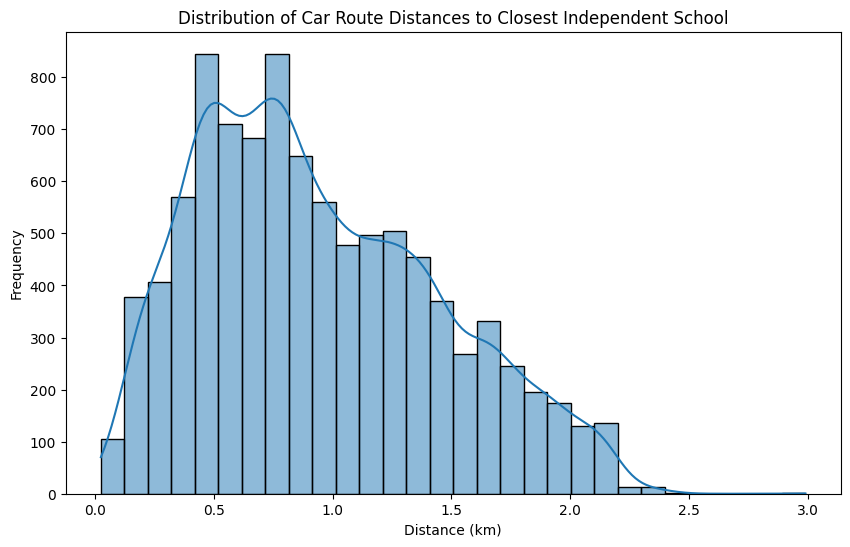

In [56]:
# plot the distribution of the car route distances to the closest primary school
plt.figure(figsize=(10, 6))
sns.histplot(house['log_distance_to_closest_school'], bins=30, kde=True)
plt.title('Distribution of Car Route Distances to Closest Independent School')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()

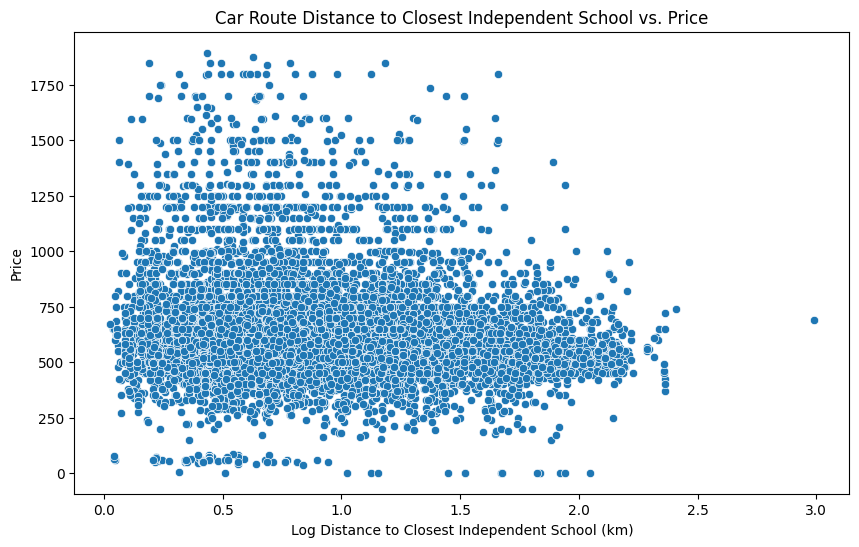

In [57]:
# scatter plot of the car route distances to the closest primary school vs. the price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=house, x='log_distance_to_closest_school', y='extracted_price')
plt.title('Car Route Distance to Closest Independent School vs. Price')
plt.xlabel('Log Distance to Closest Independent School (km)')
plt.ylabel('Price')
plt.show()

In [58]:
# Check correlation between the distance to the closest primary school and the extracted price 
house[['log_distance_to_closest_school', 'extracted_price']].corr()

,log_distance_to_closest_school,extracted_price
log_distance_to_closest_school,1.000000,-0.144937
extracted_price,-0.144937,1.000000


### Correlation to school distance

In [7]:
# import from the curated folder
house = pd.read_csv('../data/curated/house_school.csv')

In [8]:
house["log_distance_to_closest_school"] = np.log1p(house["distance_to_closest_school"])

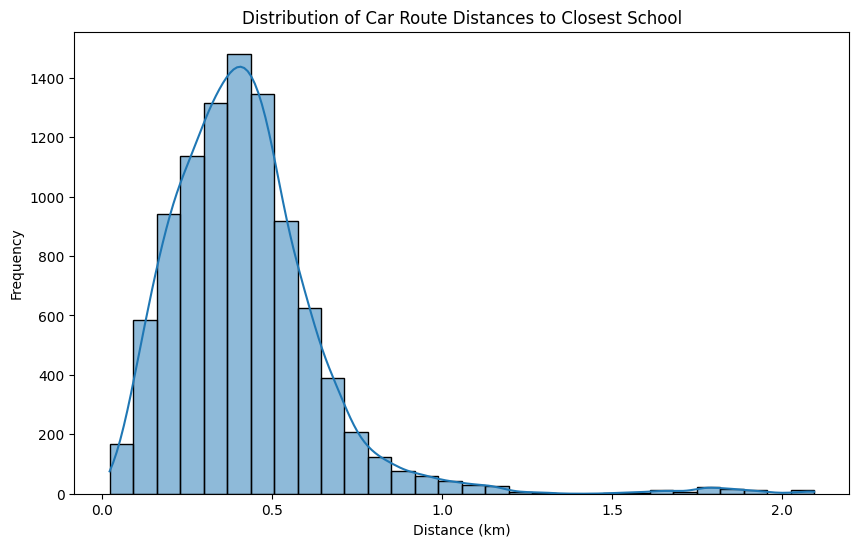

In [11]:
# plot the distribution of the car route distances to the closest primary school
plt.figure(figsize=(10, 6))
sns.histplot(house['log_distance_to_closest_school'], bins=30, kde=True)
plt.title('Distribution of Car Route Distances to Closest School')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()

In [12]:
# Check correlation between the distance to the closest primary school and the extracted price 
house[['log_distance_to_closest_school', 'extracted_price']].corr()

,log_distance_to_closest_school,extracted_price
log_distance_to_closest_school,1.000000,-0.050649
extracted_price,-0.050649,1.000000
